In [3]:
# Import libraries
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
import folium
from folium import plugins

# Set options for displaying dataframes and figures
pd.set_option('display.max_columns', None)
# Ignore the FutureWarning temporarily
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

# Load Data

In [3]:
# Get the directory where the data is stored
data_raw_directory = (os.getcwd()+"\data_raw")
# List all files in the directory
file_list = os.listdir(data_raw_directory)

# Read the csv-file --> Use latin-1 encoding instead of utf-8 encoding
df_data = pd.read_csv(filepath_or_buffer = os.path.join(data_raw_directory, file_list[0]),
                    sep=",",
                    encoding = "latin-1")

In [4]:
# Drop unnecessary columns, containing missing data
df_data.drop(columns=["Product Description", "Customer Lname", "Customer Zipcode",
                      "Order Zipcode", "Customer Email", "Customer Password", "Product Image"],
                 inplace = True)

In [5]:
# Change the date-columns to the appropriate format
df_data["order date (DateOrders)"] = pd.to_datetime(df_data["order date (DateOrders)"]).dt.date
df_data["shipping date (DateOrders)"] = pd.to_datetime(df_data["shipping date (DateOrders)"]).dt.date

## Check Raw Data

#### Distribution

In [6]:
# Prepare data for visualisation --> select columns with data types integer or float
numeric_columns = df_data.select_dtypes(include=['int64', 'float64'])

# Drop columns with data types other than integer or float
df_visualisation = df_data[numeric_columns.columns]

# Remove the ids from the data as well
df_visualisation.drop(columns=["Category Id", "Customer Id", "Department Id",
                               "Order Customer Id", "Order Id", "Order Item Cardprod Id",
                               "Order Item Id", "Product Card Id", "Product Category Id"],
                               inplace = True)

C:\Users\lukas\AppData\Local\Temp\ipykernel_11908\2016131144.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_visualisation.drop(columns=["Category Id", "Customer Id", "Department Id",


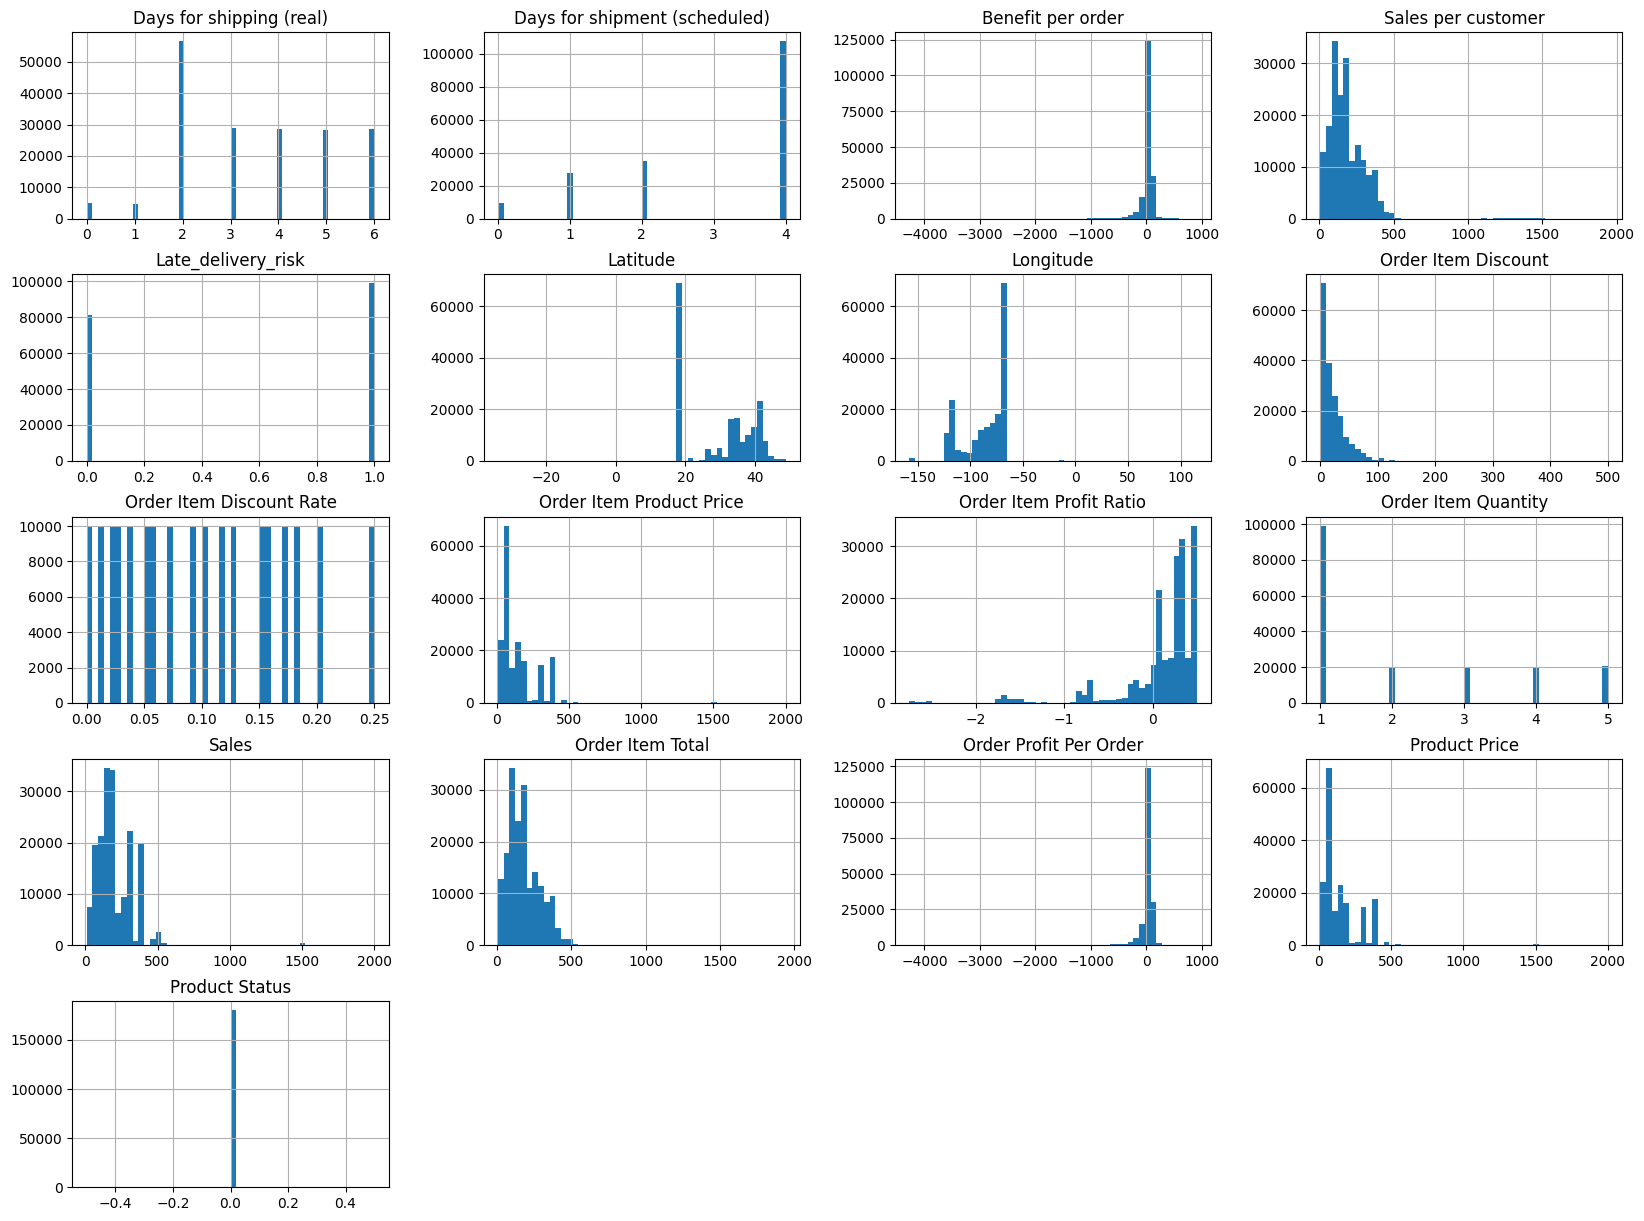

In [7]:
# Plot the data to get an inital overview
df_visualisation.hist(bins = 50, figsize = (20,15))
plt.show()

#### Sales per Department and Market

In [8]:
# Aggregate the data by market and sales value
sales_market = df_data.groupby("Market").agg({"Sales": "sum"})
# Sort the dataframe by highest order volume
sales_market = sales_market.sort_values("Sales", ascending=False)

# Aggregate the data by department and sales value
sales_department = df_data.groupby("Department Name").agg({"Sales": "sum"})
# Sort the dataframe by highest order volume
sales_department = sales_department.sort_values("Sales", ascending=False)

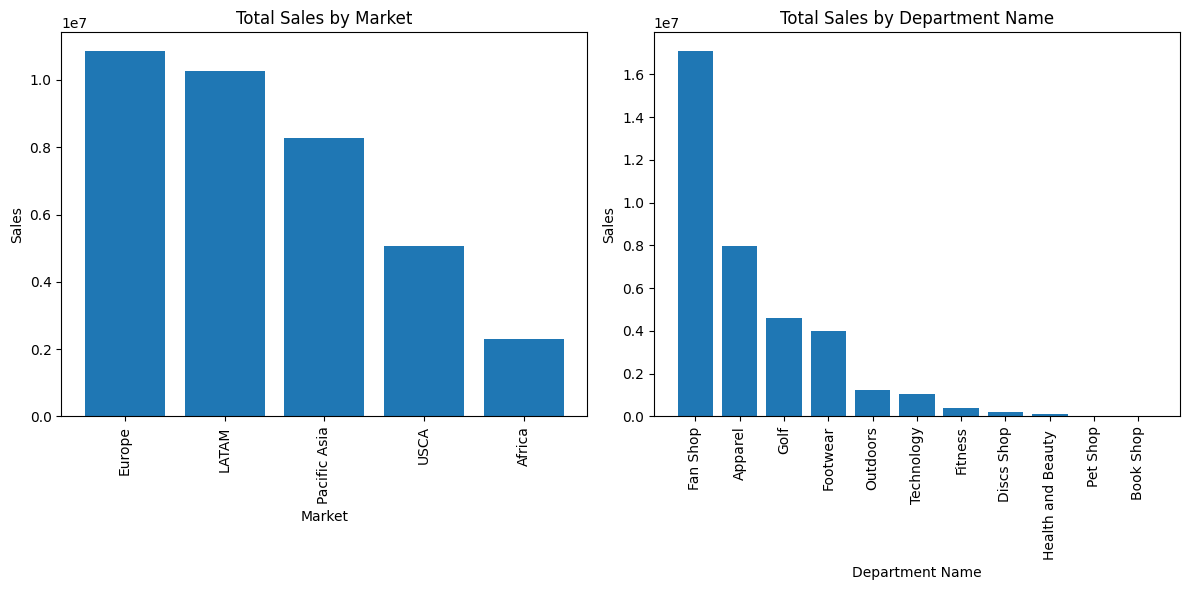

In [9]:
data = [(sales_market, "Market"), (sales_department, "Department Name")]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, (df, label) in enumerate(data):
    axes[i].bar(df.index, df["Sales"])
    axes[i].set_xlabel(label)
    axes[i].set_ylabel("Sales")
    axes[i].set_title(f"Total Sales by {label}")

    # Rotate x-axis labels by 90 degrees
    axes[i].tick_params(axis='x', rotation=90)

# Adjust spacing between the subplots
plt.tight_layout()

# Display the plots
plt.show()

In [10]:
# Aggregate the data by both "Market" and "Department Name"
sales_market_department = df_data.groupby(["Market", "Department Name"]).agg({"Sales": "sum"})
# Sort the data by total sales
sales_market_department = sales_market_department.sort_values("Sales", ascending=False)

# Create a pivot table to reshape the data
pivot_table = sales_market_department.reset_index().pivot(index="Market", columns="Department Name", values="Sales")

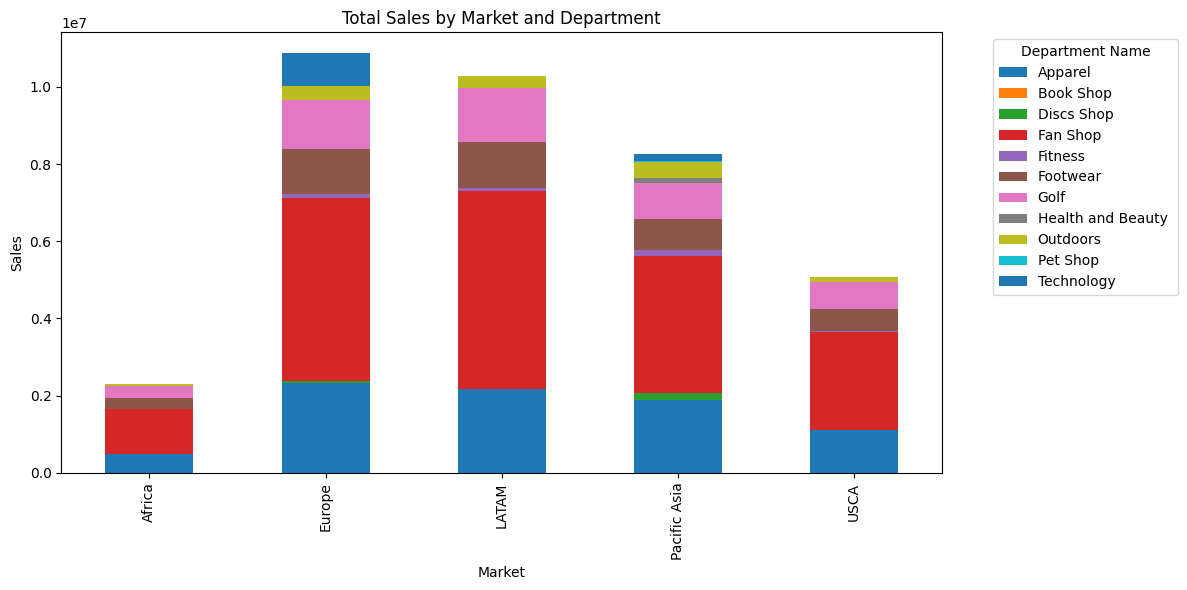

In [11]:
# Plot the stacked bar chart
pivot_table.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.xlabel("Market")
plt.ylabel("Sales")
plt.title("Total Sales by Market and Department")
plt.legend(title="Department Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

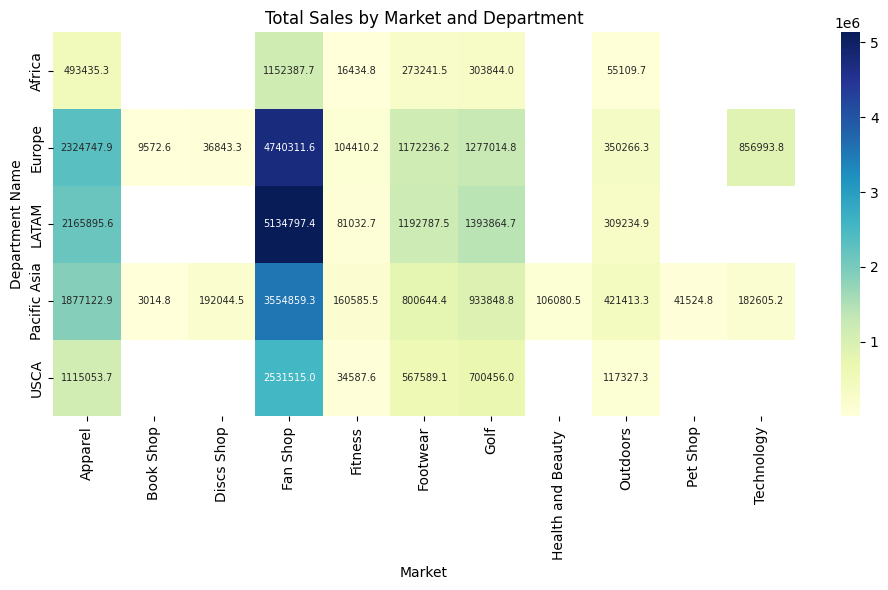

In [12]:
# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", annot_kws={"size": 7})
plt.xlabel("Market")
plt.ylabel("Department Name")
plt.title("Total Sales by Market and Department")
plt.tight_layout()
plt.show()

In [13]:
# Drop duplicate rows based on "Latitude" and "Longitude" columns, keeping the first occurrence
df_unique_locations = df_data.drop_duplicates(subset=["Latitude", "Longitude"], keep="first")
# Merge the DataFrames based on "Customer City"
df_unique_locations = df_unique_locations.groupby(["Customer City"]).agg({"Sales": "sum"})
# Create dataframe for coordinates
df_coordinaates = df_data.drop_duplicates(subset="Customer City")
# Perform an inner merge on the common key column ("Customer City")
df_locations = df_unique_locations.merge(df_coordinaates, on="Customer City", how="inner")
df_locations = df_locations[["Customer City", "Latitude", "Longitude", "Sales_x"]]
df_locations.rename(columns={"Sales_x": "Sales"}, inplace=True)

In [16]:
# Set the center of the map
map_center = [df_locations["Latitude"].mean(), df_locations["Longitude"].mean()]
map_plot = folium.Map(location=map_center, zoom_start=10)

# Prepare data for the heatmap: latitude, longitude, and intensity (sales)
heat_data = [[row["Latitude"], row["Longitude"], row["Sales"]] for index, row in df_locations.iterrows()]
plugins.HeatMap(heat_data).add_to(map_plot)
# Display the map
map_plot.save("Sales_Heatmap.html")  # Save as HTML file

# Create Clustering Data

In [17]:
# Create a seperate dataframe for clustering
columns_clustering = ["Product Name", "Order Item Discount", "Order Item Discount Rate", 
                      "Order Item Product Price", "Order Item Profit Ratio", "Order Item Quantity",
                      "Sales", "Order Item Total", "Order Profit Per Order", "Product Price"]
df_clustering = df_data[columns_clustering]
# Aggregate the data
df_clustering = df_clustering.groupby("Product Name").agg({"Order Item Quantity": "sum",
                                                           "Order Item Discount Rate": "mean",
                                                           "Sales": "sum",
                                                           "Order Item Profit Ratio": "mean"})
# Reset the index to not obtain the product name as an index
df_clustering = df_clustering.reset_index()

### Check Distribution

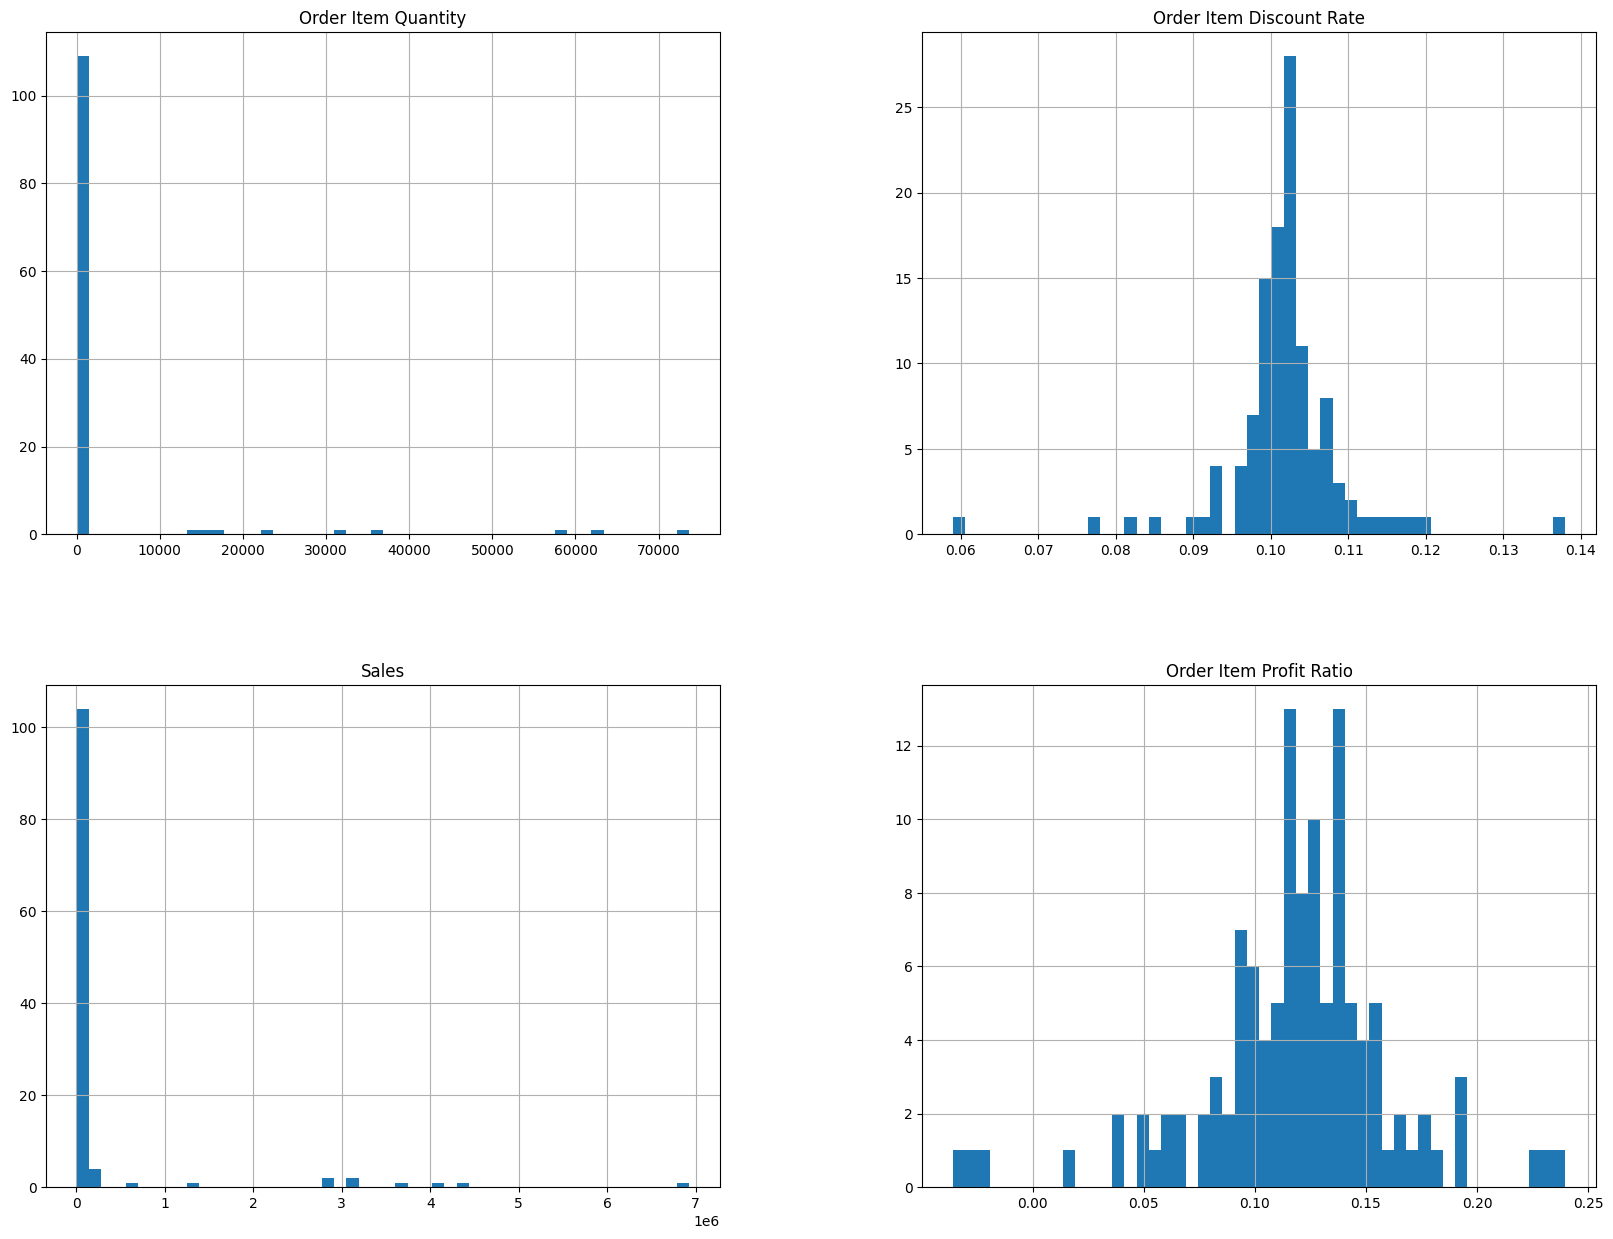

In [18]:
# Plot the data to get an inital overview
df_clustering.hist(bins = 50, figsize = (20,15))
plt.show()

In [19]:
df_clustering.head(5)

,Product Name,Order Item Quantity,Order Item Discount Rate,Sales,Order Item Profit Ratio
0,Adult dog supplies,492,0.101585,41524.800753,0.094106
1,Baby sweater,207,0.104300,12229.560379,0.139420
2,Bag Boy Beverage Holder,845,0.099785,21116.549776,0.164265
3,Bag Boy M330 Push Cart,208,0.103623,16637.919929,0.184493
4,Bowflex SelectTech 1090 Dumbbells,10,0.138000,5999.899902,0.233000


Text(0.5, 1.0, 'Scatterplot: Order Qty vs Sales Value')

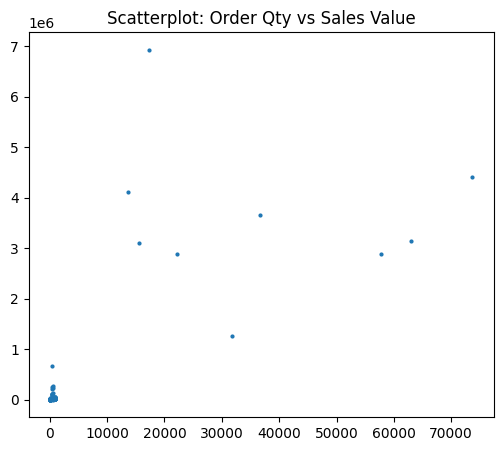

In [20]:
# Create basic Scatter plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(df_clustering["Order Item Quantity"], df_clustering["Sales"], s=4)
ax.set_title("Scatterplot: Order Qty vs Sales Value")

### Pareto Chart of Order Qty

In [21]:
# Sort the dataframe by highest order volume
df_order_qty = df_clustering.sort_values("Order Item Quantity", ascending=False)
#add column to display cumulative percentage
df_order_qty["Cumperc Qty"] = df_order_qty["Order Item Quantity"].cumsum()/df_order_qty["Order Item Quantity"].sum()*100

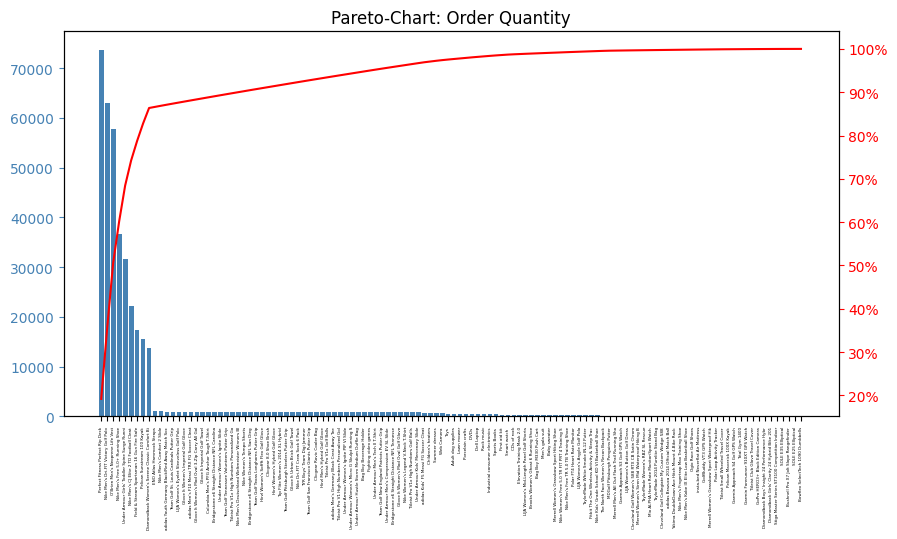

In [22]:
# Define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 2

# Create basic bar plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(df_order_qty["Product Name"], df_order_qty["Order Item Quantity"], color=color1)
ax.set_title("Pareto-Chart: Order Quantity")

# Add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df_order_qty["Product Name"], df_order_qty["Cumperc Qty"], color=color2, ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)
ax.tick_params(axis='x', rotation=90, labelsize=3) 

# Display Pareto chart
plt.show()

### Pareto Chart of Sales Value

In [23]:
# Sort by Sales
df_sales_value = df_clustering.sort_values("Sales", ascending=False)
#add column to display cumulative percentage
df_sales_value["Cumperc Sales"] = df_sales_value["Sales"].cumsum()/df_sales_value["Sales"].sum()*100

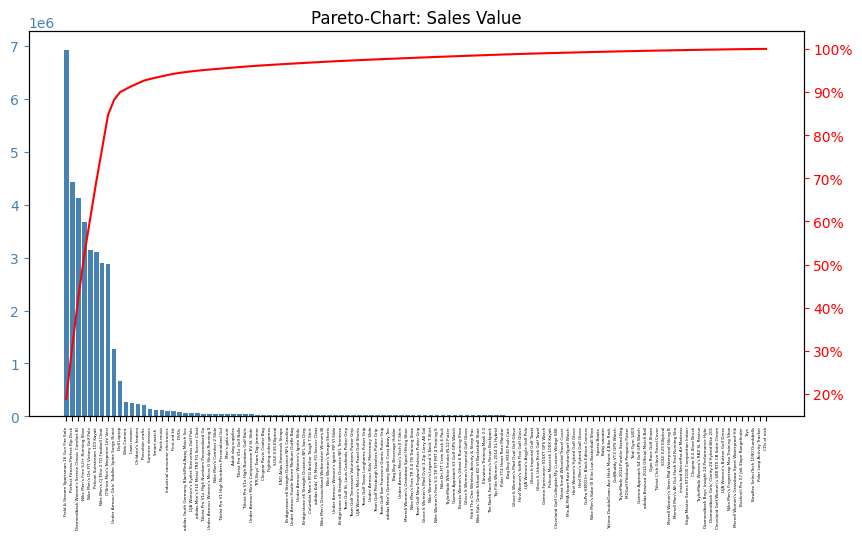

In [24]:
# Define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 2

# Create basic bar plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(df_sales_value["Product Name"], df_sales_value["Sales"], color=color1)
ax.set_title("Pareto-Chart: Sales Value")

# Add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df_sales_value["Product Name"], df_sales_value["Cumperc Sales"], color=color2, ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)
ax.tick_params(axis='x', rotation=90, labelsize=3) 

# Display Pareto chart
plt.show()

## Principal Component Analysis & KMeans

#### Scale the data

In [25]:
# Create dataframe for K-Means
df_kmeans = df_clustering.drop("Product Name", axis=1)
column_names = df_kmeans.columns


In [26]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_kmeans)
df_scaled_data = pd.DataFrame(scaled_data)
df_scaled_data.columns = column_names

## Two Clusters

In [27]:
# In order to reduce the dimensionality of the data from 4 to 2 dimension, PCA is applied to reduce the dataset to two dimensions. 
pca = PCA(n_components=2)
X2D = pca.fit_transform(df_scaled_data)
df_pca = pd.DataFrame(X2D)
df_pca.columns = ["PC1", "PC2"]
# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

In [28]:
print("Total explained variance by two PC's:", round((explained_variance_ratio[0]+explained_variance_ratio[1])*100,2), "%")

Total explained variance by two PC's: 76.29 %


Text(0.5, 1.0, 'Scatterplot of Principal Components')

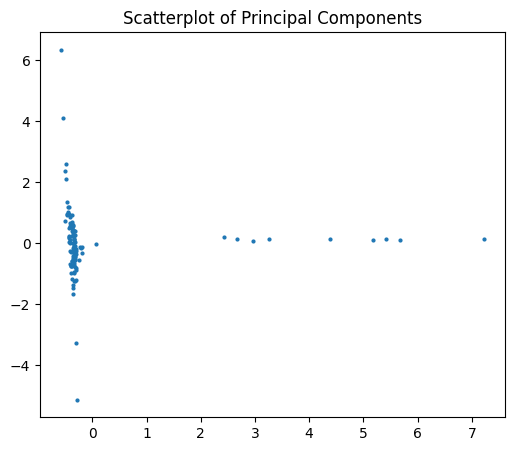

In [29]:
# Create basic Scatter plot of PC's
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(df_pca["PC1"], df_pca["PC2"], s=4)
ax.set_title("Scatterplot of Principal Components")

In [30]:
# Create lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []

# Set a range of k values, for example 1 to 10
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca) 
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_pca, kmeans.labels_))

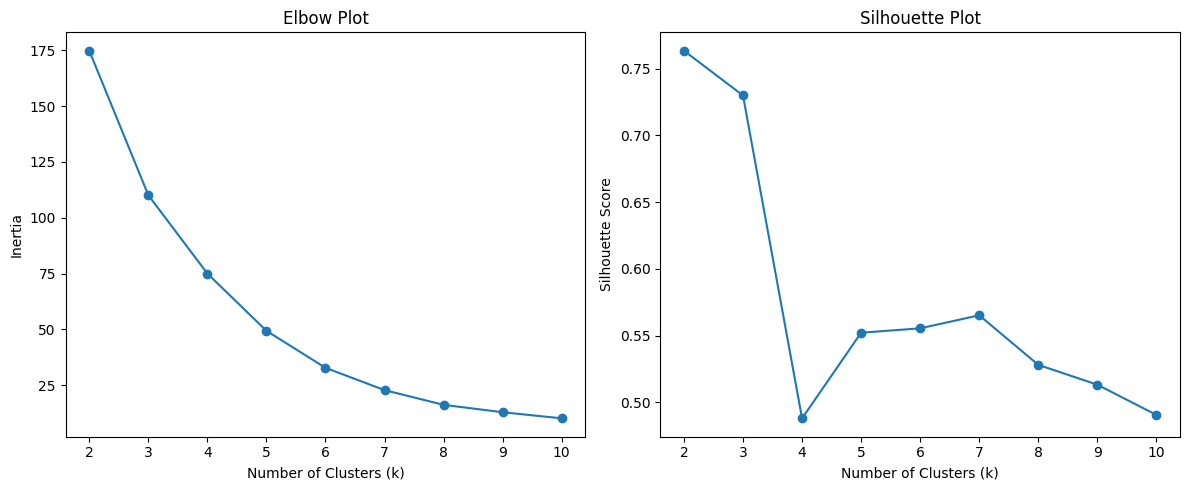

In [31]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Elbow plot
axes[0].plot(k_values, inertia, marker='o')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Plot')

# Silhouette plot
axes[1].plot(k_values, silhouette_scores, marker='o')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Plot')

# Adjust spacing between the plots
plt.tight_layout()

# Display the plots
plt.show()

#### Compute KMeans

Now we defined that there are two clusters, therfore we compute the KMeans algorithm with two clusters

In [32]:
# We have chosen two clusters so we run K-Means with number of clusters equals two
kmeans_pca = KMeans(n_clusters = 2, init = "k-means++", random_state = 42)

In [33]:
# Fit the data with the k-means pca model
kmeans_pca.fit(df_pca)

KMeans(n_clusters=2, random_state=42)

In [34]:
# Create new data frame with the original features and add the PCA scores and assigned clusters
df_pca_kmeans = pd.concat([df_kmeans.reset_index(drop = True), pd.DataFrame(df_pca)], axis = 1)
df_pca_kmeans.columns.values[-2: ] = ["Component 1", "Component 2"]
# The last column we add contains the pca k-means clustering labels
df_pca_kmeans["Segment K-Means PCA"] = kmeans_pca.labels_
# We create a new column named ‘Segment’ and map the two clusters directly inside it.
df_pca_kmeans["Segment"] = df_pca_kmeans["Segment K-Means PCA"].map({0:"first",
                                                                     1:"second"})


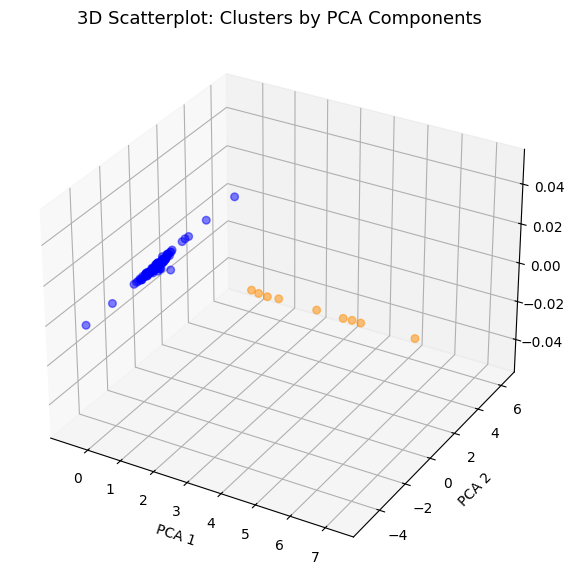

In [35]:
# Create 3D-Scatterplot of PCA
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

colors = {"first": "darkorange", "second": "blue"}

ax.scatter(df_pca_kmeans["Component 1"],
           df_pca_kmeans["Component 2"],
           c = df_pca_kmeans['Segment'].map(colors),
           marker='o', s = 30, alpha=0.5)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
plt.title("3D Scatterplot: Clusters by PCA Components", size = 13)
plt.show()

In [36]:
# Aggregate the cluster with their respective mean values for the variables
df_pca_kmeans_aggregated = df_pca_kmeans.groupby("Segment").aggregate({"Order Item Quantity" : "sum",
                                                                       "Sales" : "sum"})

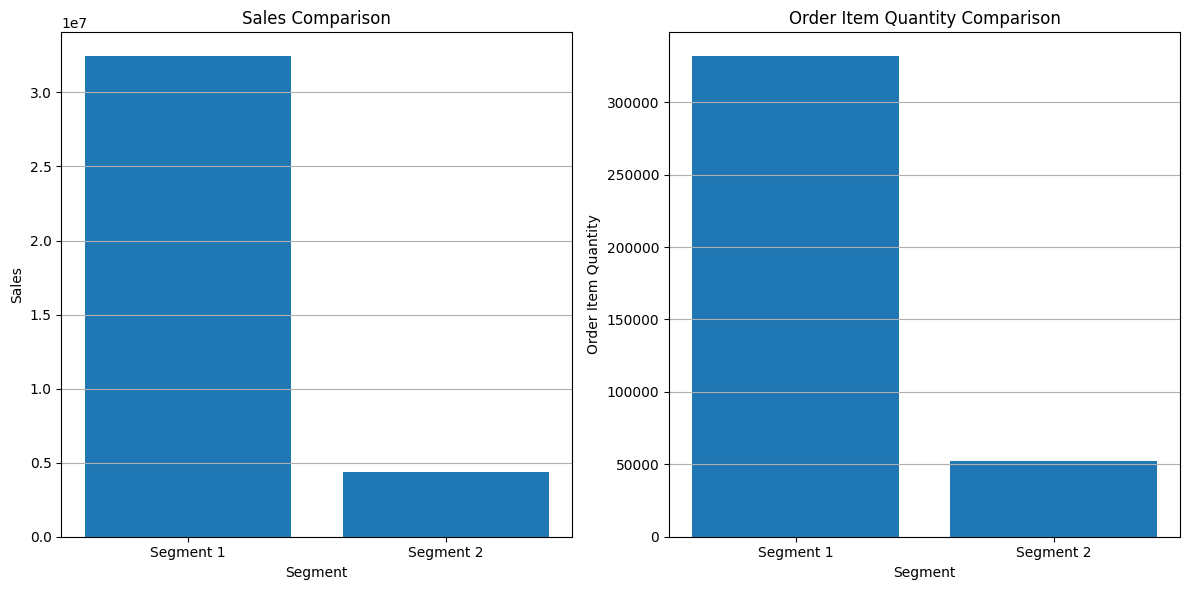

In [37]:
# Extract data for Segment 1 and Segment 2
segment1_data = df_pca_kmeans_aggregated.loc["first"]
segment2_data = df_pca_kmeans_aggregated.loc["second"]

# Extract sales and order item quantity values
sales_segment1 = segment1_data["Sales"]
sales_segment2 = segment2_data["Sales"]

order_item_quantity_segment1 = segment1_data["Order Item Quantity"]
order_item_quantity_segment2 = segment2_data["Order Item Quantity"]

# Create two separate bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for Sales
ax1.bar(["Segment 1", "Segment 2"], [sales_segment1, sales_segment2])
ax1.set_title("Sales Comparison")
ax1.set_ylabel("Sales")
ax1.set_xlabel("Segment")
ax1.grid(axis="y")

# Bar chart for Order Item Quantity
ax2.bar(["Segment 1", "Segment 2"], [order_item_quantity_segment1, order_item_quantity_segment2])
ax2.set_title("Order Item Quantity Comparison")
ax2.set_ylabel("Order Item Quantity")
ax2.set_xlabel("Segment")
ax2.grid(axis="y")

plt.tight_layout()
plt.show()


# ABC Classification

In [38]:
# Sort values by highest to lowest sales
df_abc = df_clustering[["Product Name", "Sales"]].sort_values(by="Sales",ascending=False).reset_index()
# Add cumulative sum of the sales as a new column
df_abc["cum_sum"] = df_abc["Sales"].cumsum()
# Add the cumulated percentage of the sales as a new column
df_abc["cum_per"] = df_abc["cum_sum"]/df_abc["Sales"].sum()*100
# Add the percentage of each SKU as a new column
df_abc["per"] = df_abc["cum_per"]-df_abc["cum_per"].shift(1)
# Add the first missing value in column "per" to be the first of cumulative percentage
df_abc.loc[0,"per"] = df_abc["cum_per"][0]
# Drop the second index column
df_abc.drop(columns="index", inplace=True)

In [39]:
# Define function to classify the SKUs based on their cumlated percentage revenue
def abc_classification(data):
    if data["cum_per"]<=70:
        return "A"
    elif data["cum_per"]>70 and data["cum_per"]<=95:
        return "B"
    elif data["cum_per"]>95:
        return "C"

# Apply the function to the data and add a new column for the classification
df_abc["Category"] = df_abc.apply(abc_classification, axis=1)

# Create a variable to visualise the data
abc_graph = df_abc[["Category","Product Name","Sales"]].groupby("Category").agg(Revenue=("Sales","sum"),count=("Product Name","count"))

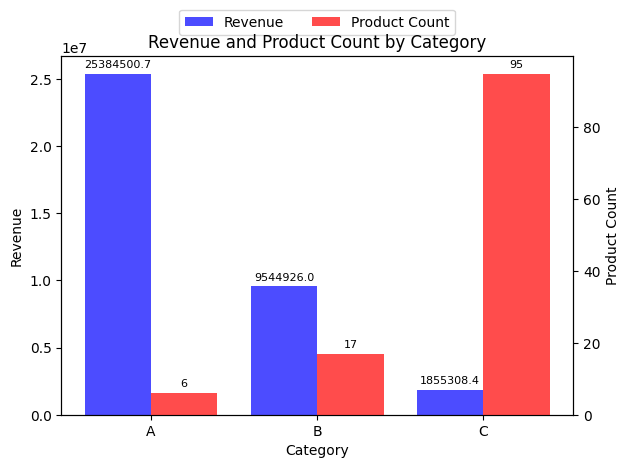

In [40]:
# Extract data for plotting
categories = abc_graph.index
revenue = abc_graph["Revenue"]
product_count = abc_graph["count"]

# Calculate the width for each bar group
bar_width = 0.4
index = list(range(len(categories)))
offset = 0.2

# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot revenue bars on the left axis
bars1 = ax1.bar([i - offset for i in index], revenue, bar_width, label='Revenue', alpha=0.7, color='b')
ax1.set_ylabel("Revenue")
ax1.set_xlabel("Category")
ax1.set_xticks(index)
ax1.set_xticklabels(categories)

# Create a twin axes on the right side
ax2 = ax1.twinx()

# Plot product count bars on the right axis
bars2 = ax2.bar([i + offset for i in index], product_count, bar_width, label='Product Count', alpha=0.7, color='r')
ax2.set_ylabel("Product Count")

# Show legend for both axes in the top-middle position
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# Function to label the bars with sales values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate('{:.1f}'.format(height),  # Format sales as a float with one decimal place
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=8)  # Set the font size for the sales labels

# Label the revenue bars with sales values
autolabel(bars1)

# Function to label the product count bars with their values
def autolabel_product_count(bars):
    for bar in bars:
        height = bar.get_height()
        ax2.annotate('{}'.format(int(height)),  # Format product count as an integer
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=8)  # Set the font size for the product count labels

# Label the product count bars with their values
autolabel_product_count(bars2)

plt.title("Revenue and Product Count by Category")
plt.tight_layout()
plt.show()

